In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

There are a *lot* of different clustering methods – we're going to review just three more here: _Mean-shift_, _Spectral Clustering_, and _Affinity Propagation_.  If you want to go even broader, check out this [comparison among all the clustering algorithms available in sklearn](http://scikit-learn.org/stable/modules/clustering.html).

For all three methods, we'll be using the same simulated dataset, with three "blobs."  We won't need to normalize the data since it is simulated and comes pre-normalized, but with real data normalization will be important to make sure all your features are given equal weight in finding a clustering solution.

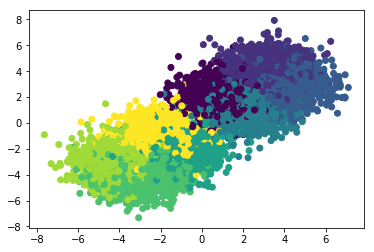

In [55]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

# The coordinates of the centers of our blobs.
# centers = [[2, 2], [-2, -2], [2, -2]] # Original Attempt
# centers = [[20,20], [-20,-20], [20,-20]] # Much larger
# centers = [[.1,.1], [-.1,-.1], [.1,-.1]] # Much Smaller
centers = [[1,2], [3,4], [4,3], [2,1], [-1, -2], [-3,-4], [-4,-3], [-2,-1]] # More Blobs

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

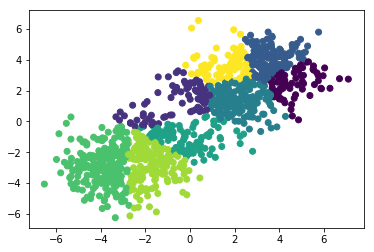

Comparing k-means and mini batch k-means solutions:
col_0   0   1   2   3   4   5    6   7
row_0                                 
0       0   8  56   4   0   0    0   0
1      48   0   0   7   3   0    0  20
2       0  77  51   1   0   0    0   0
3      58   8  17  80   0   0    0   1
4       3   0   0  16  47   1    0  36
5       0   0   0   0   6  57  129  21
6       0   0   0   0  68  56   11  32
7      29  42   5   2   0   0    0   0


In [57]:
# K means

from sklearn.cluster import MiniBatchKMeans

minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=8, #Change to 8 on more blobs
    batch_size=200)
minibatchkmeans.fit(X_train)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_train)


plt.scatter(X_train[:, 0], X_train[:, 1], c=predict_mini)
plt.show()


print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_train))

In [58]:
# Mean_shift
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 2


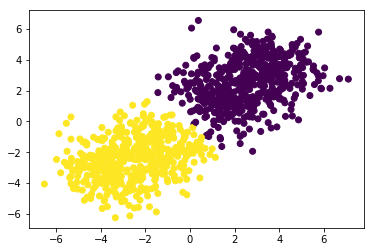

Comparing the assigned categories to the ones in the data:
col_0    0    1
row_0          
0      137    1
1      135    0
2      129    0
3      108    2
4        4  120
5        0  114
6        0  140
7        1  109


In [59]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

Not bad at all.

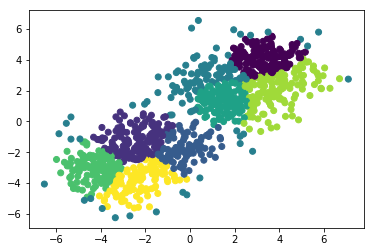

Comparing the assigned categories to the ones in the data:
col_0   0   1   2   3   4   5   6   7
row_0                                
0       2   0   0  59  69   0   8   0
1      91   0   0  24   4   0  16   0
2      47   0   0   5   2   0  75   0
3       3   0   7  10  55   0  35   0
4       0  28  69   2   0   1   0  24
5       0   9   4   4   0  30   0  67
6       0  26   0   8   0  93   0  13
7       0  81  16   4   1   2   0   6


In [65]:
# Spectrail Clustering

from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=8 #Change to 8 on more blobs

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

These clusters look familiar, though the two dots at the top are interesting.

In [62]:
# Affinity Propagation

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))


Done
Estimated number of clusters: 28


Affinity propagation is known to overestimate the number of clusters – in this case, we have an absolutely absurd number.  Let's see what that looks like:

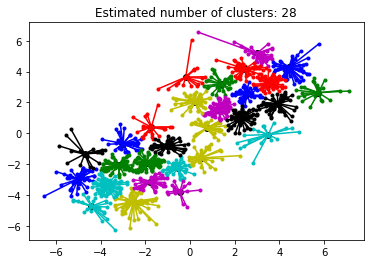

In [63]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

# DRILL: Mo' blobs, mo' problems?

You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least three different blob configuations, then run the four methods ($k$-means, mean shift, spectral clustering and affinity propagation) on each one.  Write up a report for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups. 

How these methods differentiated from each other:

K-Means:  Needed to assign the amount of clusters to find.  Does a pretty good job of finding the mean centroid at that point but will only create as many centroids as the user defines.  This can be problematic if the user doesnt know how many centroids there are.

Mean shift:  This method is able to estimate the amount of centroids through an approximation of density.  This method did very well when the clusters were well spaced but worse as the clusters were close together as the algorithm could only find one cluster when there were more.  This method is sensitive to bandwith to detect clusters when smaller density.

Spectral - Seems to create a group of outliners that surround the other clusters when the clusters are close together.  Must also define how many clusters the user wants to see.

Affinity Prob - Finds how many clusters it thinks there should be each time.  When the clusters are close together, AP finds fewer clusters.  When spaced apart, AP finds many more clusters.  One instance when the clusters were very far apart, AP correctly identified one cluster but then identified over 600 in the next 2 clusters.  Seems to work better when the clusters are close together.